# Chimera Graph

## Objective

* Obtain a graph representation for chimeras measured by Liu et al.
* test link prediction task with classical Node Embeddings.

In [27]:
import pandas as pd
import sup_data_to_fasta as sdtf
from collections import Counter
import itertools
import pickle

In [28]:
raw_data_df = sdtf.load_xlsx('../data/Liu_sup5_data.xlsx')

In [29]:
bio_df_dict, data_df_dict = sdtf.map_raw_data_to_queries_and_expected(raw_data_df)

In [4]:

def get_kmer_code(k):
    nts=['A','C','G','T']
    kmer_code = {}
    for i, kmer in enumerate(itertools.product(nts, repeat=k)):
        kmer_code[''.join(kmer)] = i
    
    return kmer_code

def to_kmer_vec(seq, k, kmers_codes):
    kmer_vec = [0]*(4**k)
    kmers_counts = Counter([seq[i:i+k] for i in range(len(seq)-k+1)])
    kmer_vec = [kmers_counts.get(kmer, 0) for kmer in kmers_codes]
    return kmer_vec

edges_properties = ['from', 'to', 'ligation from', 'ligation to', "Odds Ratio", "Fisher's exact test p-value", "Number of interactions"]
nodes_properties = ['type', 'Strand','origin']
kmer_sz = 4
kmers_code = get_kmer_code(kmer_sz)

def to_numeric_data(data_df_dict, nodes_properties, edges_properties):
    for df in data_df_dict.values():
        for prop in edges_properties:
            df[prop] = pd.to_numeric(df[prop], errors='coerce')
            df[prop].fillna(-1, inplace=True)

        for prop in nodes_properties:
            df[prop] = df[prop].astype("category")
    return data_df_dict

def encode_kmer_data(data_df_dict, kmers_code, kmer_sz):
    for df in data_df_dict.values():
        df['seq'] = df['seq'].apply(lambda x: to_kmer_vec(x, kmer_sz, kmers_code))
    return data_df_dict


In [5]:
data_df_dict = to_numeric_data(data_df_dict, nodes_properties, edges_properties)
encode_kmer_data(data_df_dict, kmers_code, kmer_sz)
nodes_properties.append('seq')

/tmp/ipykernel_1157/3001051763.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[prop].fillna(-1, inplace=True)
/tmp/ipykernel_1157/3001051763.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.met

In [6]:
data_df = data_df_dict['EP-OD0.5']
data_df.head()

,name,Strand,from,to,ligation from,ligation to,Number of interactions,Odds Ratio,Fisher's exact test p-value,type,seq,origin,chimera_idx,query_id
0,thrL(SL1344_0001),+,146,170,182.0,198.0,10,7.896213,1.180000e-06,5UTR,"[2, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 1, ...",RNA1,0,713c8bd24ef5471685e58deb707a8e59
1,SL1344_0018(SL1344_0018).SL1344_0019(SL1344_00...,+,19997,20004,20042.0,20047.0,22,2121.390825,8.550000e-57,IGR,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",RNA1,1,10f2b4bb74154c7aa59716a8dcd51fd4
2,SL1344_0032(SL1344_0032).SL1344_0033(SL1344_00...,+,35145,35150,-1.0,-1.0,13,8773.839147,2.280000e-36,IGR,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",RNA1,2,ef1d01554f074e9da48c5dfa8a37966d
3,StyR-29(ncRNA0419),-,52558,52583,52529.0,52539.0,21,23.086070,1.370000e-21,sRNA,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",RNA1,3,9dd60914df364e77854731ee5a9456c7
4,StyR-29(ncRNA0419),-,52559,52598,52529.0,52534.0,10,8.940498,3.200000e-07,sRNA,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",RNA1,4,7ea75d34a74743379e26707336bebe2f


In [7]:
import networkx as nx

def create_chimera_graph(data_df, gname, nodes_properties, edges_properties):
    
    # Create an empty graph
    G = nx.Graph(name=gname)

    # Iterate over the rows of the dataframe
    for _, row in data_df.iterrows():
        query_id = row['query_id']
        chimera_idx = row['chimera_idx']

        # Add the node to the graph
        G.add_node(query_id)
        
        # Add the properties to the node
        for att in nodes_properties:
            nx.set_node_attributes(G, row[att], att)

        # Find other nodes with the same chimera_idx
        nodes_with_same_chimera = data_df[data_df['chimera_idx'] == chimera_idx]['query_id']

        edges_att = {}
        # Add edges between the current node and other nodes with the same chimera_idx
        for node in nodes_with_same_chimera:
            if node != query_id:
                G.add_edge(query_id, node)
                
                edges_att[(node, query_id)] = {att: row[att] for att in edges_properties}
                nx.set_edge_attributes(G, edges_att)
    
    return G

In [8]:
chimeras_graphs = {k: create_chimera_graph(df, k, nodes_properties, edges_properties) for k,df in data_df_dict.items()}

In [9]:
ep_chimeras = chimeras_graphs['EP-OD0.5']

In [10]:
import matplotlib.pyplot as plt

def plot_chimera_graph(graph, node_features=None, edge_features=None):
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Set the layout algorithm
    pos = nx.spring_layout(graph)

    # Customize node appearance
    nx.draw_networkx_nodes(graph, pos, node_color='lightblue', node_size=20, alpha=0.8)
    
    # Customize edge appearance
    nx.draw_networkx_edges(graph, pos, edge_color='black', width=0.5, alpha=0.5)

    # Remove axis
    plt.axis('off')

    # Add a title
    plt.title(f'Chimera Graph {graph.name}')

    # Show the plot
    plt.show()


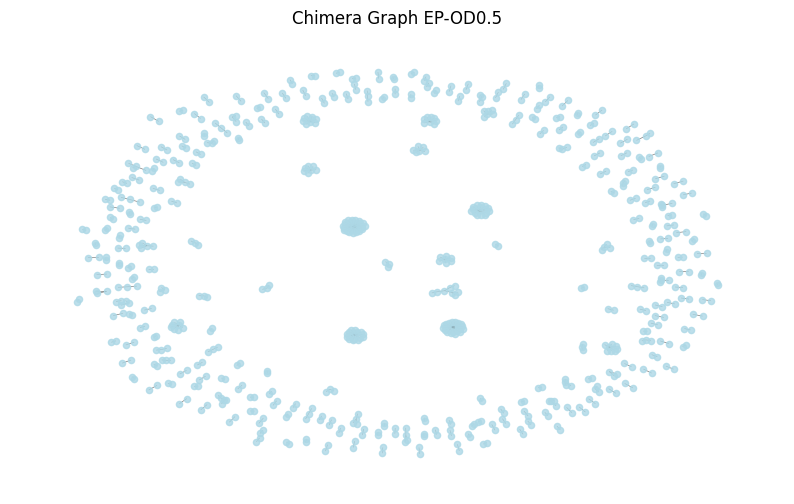

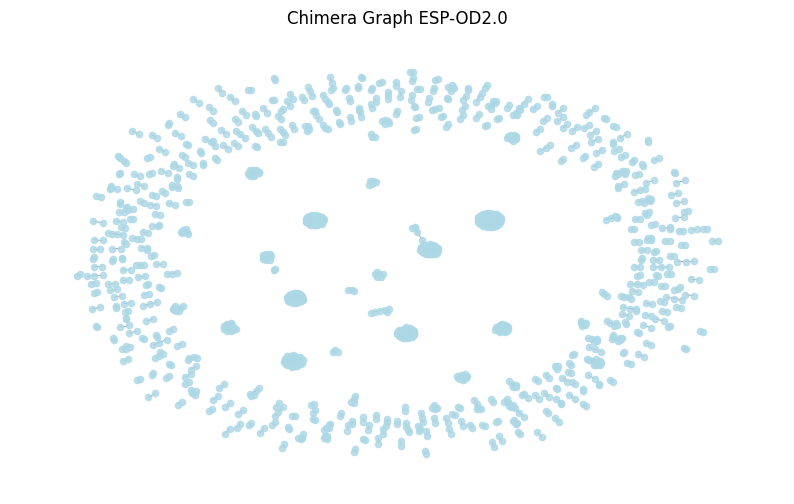

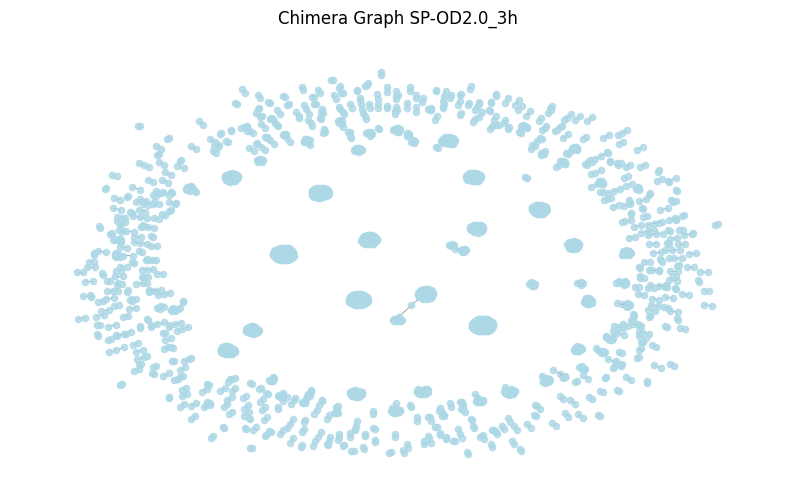

In [11]:
for key, graph in chimeras_graphs.items():
    plot_chimera_graph(graph)


In [12]:
import torch
from torch_geometric.data import Data


def get_tensor_data_loader(graph, nodes_properties, edges_properties):
    # Get the nodes and edges of the graph
    nodes = list(graph.nodes())
    edges = list(graph.edges())

    # Create the node features tensor
    attributes_values = [[node[att] for att in nodes_properties] for node in graph.nodes()]
    x = torch.tensor(attributes_values, dtype=torch.float)

    # Create the edge index tensor
    edge_index = torch.tensor([[nodes.index(edge[0]), nodes.index(edge[1])] for edge in edges], dtype=torch.long).t().contiguous()

    edges_attributes_values = [[float(graph.get_edge_data(edge[0], edge[1])[att]) for att in edges_properties] for edge in edges]
    edges_attributes = torch.tensor(edges_attributes_values, dtype=torch.float)

    # Create the data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edges_attributes)
    data.num_nodes = len(nodes)
    
    return data

def write_tensor_data_dict_loader(data, name, out_dir):
    data_dict = data.to_dict()
    with open(f'{out_dir}/{name}.pkl', 'wb') as fp:
        pickle.dump(ep_tensor_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    


In [13]:
tensors_loaders = {k: get_tensor_data_loader(g, [], edges_properties) for k,g in chimeras_graphs.items()}

In [14]:
ep_tensor_loader = tensors_loaders['EP-OD0.5']

In [15]:
ep_tensor_loader.is_undirected()

False

In [16]:
obj = ep_tensor_loader.cpu()

In [18]:
ep_tensor_dict = ep_tensor_loader.to_dict()

In [26]:
import pickle

with open('ep_data_dict.pkl', 'wb') as fp:
    pickle.dump(ep_tensor_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)